# Designing HybSeq Probes from a large sequence alignment


One of the most important considerations when designing probes for targeted sequencing is how related the the source sequences are to the potential samples that will be enriched. In phylogenetic studies of non-model organisms, there may not be prior sequences available in the target taxa, but minimizing sequence divergence is still important.

One solution is to use any existing sequence data to design probes from multiple ortholgous sources per gene. This effectively increases probe tiling and should also broaden the use of the probe set to more divergent taxa. Given a sequence alignment, we can choose sequences that are representative of specific clades, but this may be biased. 

Instead, we can let the data tell us what the most representative sequences should be. In this notebook we will generate pairwise distance matrices from DNA sequence alignments. The distances will be clustered using one or more multivariate statistics techniques (such as k-means clustering or discrimant analysis) to explore the optimal number of clusters for the alignment, and we will select representative sequences from each cluster.

We will use Python implementations of distance matrices and visualizations taken from the Introduction to Applied Bioinformatics: http://readiab.org/book/latest/2/3


In [1]:
%matplotlib inline
from skbio import TabularMSA, DNA, DistanceMatrix
from skbio.sequence.distance import hamming
import pandas as pd

fasta_filename = "/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/genes/4471/FNA2AA-upp-masked.fasta"
angiosperm_id_fn = "/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/1kp_angio_codes.txt"
angio_1kp_ids = set([x.rstrip() for x in open(angiosperm_id_fn)])


## Reading the data

The MSA has a multiple sequence alignemnt of one gene from 1KP. We keep only the sequences from Angiosperms, including genome sequence.


In [2]:
msa = TabularMSA.read(fasta_filename, constructor=DNA)
seqs_to_keep = []
for seq in msa:
    if seq.metadata["id"] in angio_1kp_ids:
        seqs_to_keep.append(seq)
        
angio_msa = TabularMSA(seqs_to_keep)        
angio_msa.reassign_index(minter="id")
angio_msa.shape

Shape(sequence=641, position=9390)

Now that the alignment contains only angiosperms, remove the positions that are only gaps:

In [3]:
angio_msa_dict = angio_msa.to_dict()
angio_msa_df = pd.DataFrame(angio_msa_dict)

#This might throw an error if there are ever any positions without gaps. Seems unlikely for this dataset...

gapped_columns = angio_msa_df.apply(lambda x: x.value_counts()[b"-"],axis=1)

#This could be modified to remove columns that have 90% gaps, etc.

angio_msa_df_nogaps = angio_msa_df[gapped_columns != len(angio_msa_df.columns)]

#In skbio, DNA sequences are stored as bytecode, (b'A') so need to convert back to strings

nogap_seqs = [DNA(angio_msa_df_nogaps[i].str.decode("utf-8").str.cat(), metadata = {"id":i}) for i in angio_msa_df_nogaps]
angio_msa_nogap = TabularMSA(nogap_seqs)
angio_msa_nogap.write("/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/4471.onlyangios.fasta")

angio_msa_nogap.shape


Shape(sequence=641, position=5730)

## Distance Matrix

We calculate the "Hamming distance" as described here: http://readiab.org/book/latest/2/4#6.3

The Hamming distance between two equal-length sequences is the proportion of differing characters.



In [4]:
hamming_dm = DistanceMatrix.from_iterable(angio_msa_nogap, metric=hamming, key='id')
hamming_dm["Ambtr_v1.0.27","Orysa_v7.0"]
#_ = hamming_dm.plot(cmap='Greens', title='Hamming distances between sequences')

0.1169284467713787

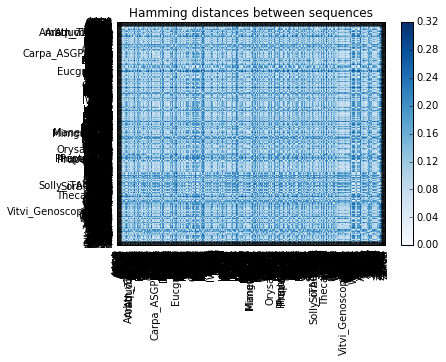

In [5]:
_ = hamming_dm.plot(cmap='Blues', title='Hamming distances between sequences')

In [6]:
hamming_dm_df = hamming_dm.to_data_frame()

In [7]:
hamming_dm_df.to_csv("/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/4471_angio_dm.csv")

## K-means clustering 

Based on example from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#example-cluster-plot-kmeans-digits-py

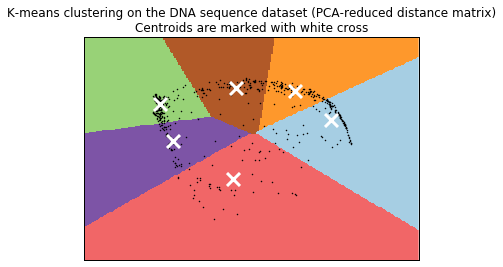

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

n_digits = 6
pca = PCA().fit(hamming_dm_df)

reduced_data = PCA(n_components=2).fit_transform(hamming_dm_df)

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the DNA sequence dataset (PCA-reduced distance matrix)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

The figure shows the PCA transformation of the distance matrix-- the axes correspond to PCA1 and PCA2.

The polygons are drawn to estimate the cluster boundaries in two dimensions.

The white X represents the "centroid" of each cluster.

## Getting within-cluster distances

Now that we have predicted clusters, are these clusters sufficient to have all sequences within the cluster be no more than 15% divergent?

For each cluster, we figure out which of the real sequences in each cluster is closest to the centroid (Euclidean distance). Then we figure out the maximum pairwise distance between any two sequences in each cluster, and the maximum distance between the representative "centroid" sequence and any other sequence in the cluster. 


In [9]:
#Group the distance matrix by kmeans clusters
from scipy.spatial import distance

grouped = hamming_dm_df.groupby(kmeans.labels_)
for name,group in grouped:
    print("Group number: {}".format(name))
    
    #Find the sample that is closest to the centroid. This is a pd Dataframe row index.
    closest_to_centroid = pd.DataFrame(reduced_data).groupby(kmeans.labels_).get_group(name).apply(
        lambda x: distance.euclidean(x,kmeans.cluster_centers_[name]), axis=1).sort_values().index[0]
    print("Number of sequences in group: {}".format(len(group)))
    
    #Reduce the distance matrix to be square within the group
    reduced_group = group[group.index]
    print("Max distance within group: {}".format(max(reduced_group.apply(max))))
    closest_id = hamming_dm_df.index[closest_to_centroid]
    print("ID closest to centroid (Euclidean): {}".format(closest_id))
    
    print("Furthest within-group Hamming distances to closest ID:")
    print(reduced_group[closest_id].sort_values(ascending=False)[0:2])
    print()

Group number: 0
Number of sequences in group: 109
Max distance within group: 0.1769633507853403
ID closest to centroid (Euclidean): XMBA
Furthest within-group Hamming distances to closest ID:
HANM    0.167714
QNOC    0.158988
Name: XMBA, dtype: float64

Group number: 1
Number of sequences in group: 258
Max distance within group: 0.13507853403141362
ID closest to centroid (Euclidean): MVRF
Furthest within-group Hamming distances to closest ID:
LPGY          0.110646
Theca_v1.1    0.106981
Name: MVRF, dtype: float64

Group number: 2
Number of sequences in group: 50
Max distance within group: 0.3183246073298429
ID closest to centroid (Euclidean): DUQG
Furthest within-group Hamming distances to closest ID:
UAXP    0.277138
KEGA    0.275393
Name: DUQG, dtype: float64

Group number: 3
Number of sequences in group: 85
Max distance within group: 0.14048865619546247
ID closest to centroid (Euclidean): BAHE
Furthest within-group Hamming distances to closest ID:
QACK    0.116230
PPQR    0.101745


### Issues

For this gene with five clusters, it appears that there is one group (4) that has high within-cluster distances. The maximum distance between the "representative" sequence and any other sequence in the group is 0.21. This exceeds the goal of 15% divergence, recommended by MycroArray.

However, in the current version of scikit-bio, there is only one option for calculating distance: Hamming distance. According to the docs:

    "Characters that may be considered equivalent in certain contexts (e.g., - and . as gap characters) are treated as distinct characters when computing Hamming distance."


Therefore, if two sequences do not have a lot of alignment overlap, they will appear to be very dissimilar when they are not. Getting around this may require some work, because I would have to define my own distance metric. 

## Spectral clustering
from: http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering

http://scikit-learn.org/stable/auto_examples/cluster/plot_face_segmentation.html#example-cluster-plot-face-segmentation-py

Note from the tutorial:

    Warning Transforming distance to well-behaved similarities

    Note that if the values of your similarity matrix are not well distributed, e.g. with negative values or with a distance matrix rather than a similarity, the spectral problem will be singular and the problem not solvable. In which case it is advised to apply a transformation to the entries of the matrix. For instance, in the case of a signed distance matrix, is common to apply a heat kernel:

`similarity = np.exp(-beta * distance / distance.std())`

    See the examples for such an application.

In [10]:
import numpy as np

similarity = np.exp(-2 * hamming_dm_df / hamming_dm_df.std()).as_matrix()
similarity

array([[  1.00000000e+00,   1.00533622e-02,   6.08621083e-04, ...,
          7.28404120e-03,   1.62378024e-03,   2.31137114e-02],
       [  1.24688755e-02,   1.00000000e+00,   1.67434129e-03, ...,
          1.62907477e-02,   3.38371428e-03,   3.61758958e-02],
       [  2.26279984e-03,   4.01825929e-03,   1.00000000e+00, ...,
          2.21693661e-03,   4.79424880e-02,   6.58404689e-03],
       ..., 
       [  8.28064814e-03,   1.48936080e-02,   7.20437800e-04, ...,
          1.00000000e+00,   1.62378024e-03,   1.52081865e-02],
       [  3.52517351e-04,   6.18994387e-04,   1.03499577e-02, ...,
          2.84981923e-04,   1.00000000e+00,   7.71269690e-04],
       [  2.84686019e-02,   3.72626120e-02,   3.12512313e-03, ...,
          1.72460340e-02,   4.21040027e-03,   1.00000000e+00]])

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:629: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


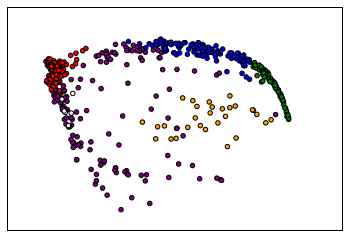

In [11]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import spectral_clustering

labels = spectral_clustering(similarity,n_clusters=6)
colormap = np.array(["r","g","b","w","purple","orange"])
plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=colormap[labels])
plt.xticks(())
plt.yticks(())
plt.show()